# EXAMEN FINAL

In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xlwings as xw

## I/ Tronc commun

#### Étape 1: Importer et fusionner les fichiers Excel

In [104]:
import os

base_directory = '/Users/sam/Desktop/Python/examen_data'
file_names = [f'Ventes_2023_Part_{i}.xlsx' for i in range(1, 11)]
file_paths = [os.path.join(base_directory, file_name) for file_name in file_names]
data_frames = [pd.read_excel(file_path) for file_path in file_paths]
data = pd.concat(data_frames, ignore_index=True)

#### Étape 2: Convertir les dates

In [105]:
data['Date'] = pd.to_datetime(data['Date'])

#### Étape 3: Vérifier et remplir les données manquantes

In [106]:
data.ffill(inplace=True)

#### Étape 4: Calculer le chiffre d'affaire total et par produit

In [107]:
CA = data.groupby("Produit")["Chiffre d'affaires"].agg(["sum", "mean"])

#### Étape 5: Créer une pivot table des chiffres d'affaires par mois et région

In [108]:
data['Mois'] = data['Date'].dt.month
pivot_table = data.pivot_table(values="Chiffre d'affaires", index="Mois", columns="Région", aggfunc="sum")

#### Étape 6: Importer le fichier référentiel et jointure

In [109]:
referentiel_path = '/Users/sam/Desktop/Python/examen_data/referentiel.xlsx'
referentiel = pd.read_excel(referentiel_path)
data = pd.merge(data, referentiel, on='Produit')

#### Étape 7: Créer une colonne 'mois' de ventes

In [110]:
data['mois'] = data['Date'].dt.month_name()

#### Étape 8: Graphique de l'évolution du chiffre d'affaire mensuel par produit

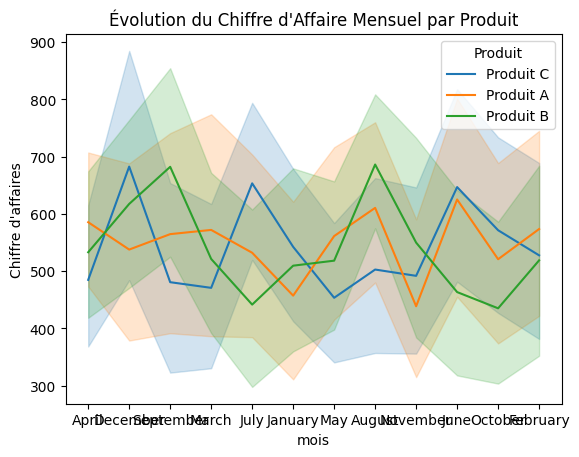

In [111]:
sns.lineplot(data=data, x="mois", y="Chiffre d'affaires", hue="Produit")
plt.title("Évolution du Chiffre d'Affaire Mensuel par Produit")
plt.show()

#### Étape 9: Boxplot des prix unitaires par produit

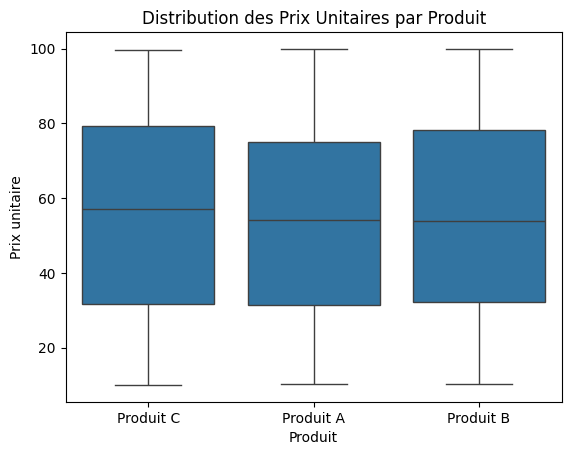

In [112]:
sns.boxplot(x='Produit', y='Prix unitaire', data=data)
plt.title('Distribution des Prix Unitaires par Produit')
plt.show()

#### Étape 10: Création d'un fichier Excel avec xlwings

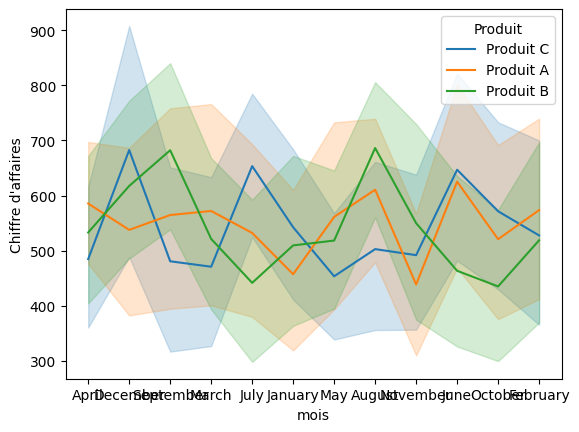

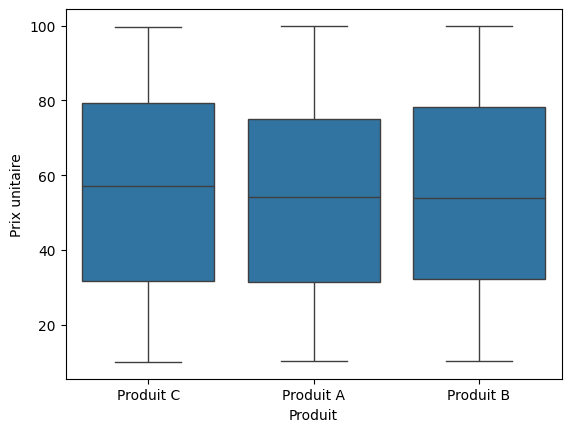

In [113]:
with xw.App(visible=False) as app:
    wb = xw.Book()
    sheet1 = wb.sheets.add('Data')
    sheet2 = wb.sheets.add('Graphs')
    sheet3 = wb.sheets.add('Summary')

    sheet1.range('A1').value = data
    sheet3.range('A1').value = CA
    sheet3.range('A10').value = pivot_table

    # Enregistrer le graphique comme image et insérer dans Excel
    fig, ax = plt.subplots()
    sns.lineplot(data=data, x="mois", y="Chiffre d'affaires", hue="Produit", ax=ax)
    fig.savefig("monthly_sales.png")
    sheet2.pictures.add("monthly_sales.png", name="Sales Chart", update=True)

    fig, ax = plt.subplots()
    sns.boxplot(x="Produit", y="Prix unitaire", data=data, ax=ax)
    fig.savefig("price_boxplot.png")
    sheet2.pictures.add("price_boxplot.png", name="Price Boxplot", update=True)

    wb.save("Analyse_CA.xlsx")
    wb.close()

## II/ Tronc avancé 

#### Étape 1: Identifier les produits dont la vente est la plus fluctuante

In [114]:
# Calcul de la variance des ventes par produit et par mois
sales_variance = data.groupby(['Produit', 'Mois'])['Quantité'].sum().unstack().var(axis=1)
most_fluctuating_products = sales_variance.sort_values(ascending=False)
print("Produits avec les ventes les plus fluctuantes :\n", most_fluctuating_products)

Produits avec les ventes les plus fluctuantes :
 Produit
Produit A    6392.568182
Produit B    3848.265152
Produit C    1945.060606
dtype: float64


#### Étape 2: Trouver l'influence des prix sur les quantités vendues

In [115]:
import statsmodels.api as sm

# Préparation des données pour la régression
X = data['Prix unitaire']  # Variable explicative
y = data['Quantité']       # Variable à expliquer
X = sm.add_constant(X)     # Ajouter une constante pour l'intercept

# Régression linéaire
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               Quantité   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.5952
Date:                Mon, 22 Apr 2024   Prob (F-statistic):              0.441
Time:                        11:37:49   Log-Likelihood:                -3126.5
No. Observations:                1000   AIC:                             6257.
Df Residuals:                     998   BIC:                             6267.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            10.3290      0.406     25.428

#### Étape 3: Tester la différence de ventes entre le premier et le dernier trimestre

In [116]:
from scipy.stats import ttest_ind

# Séparation des données de ventes par trimestre
first_quarter_sales = data[data['Mois'].isin([1, 2, 3])]['Quantité']
last_quarter_sales = data[data['Mois'].isin([10, 11, 12])]['Quantité']

# Test t de Student
t_stat, p_value = ttest_ind(first_quarter_sales, last_quarter_sales, equal_var=False)
print("T-statistic:", t_stat)
print("P-value:", p_value)

T-statistic: -0.30946210109185246
P-value: 0.7571083877450115


#### Dernière étape: Convertion des résultats sur excel

In [117]:
import xlwings as xw

# Ouverture de l'application Excel et chargement du livre existant
with xw.App(visible=False) as app:
    wb = xw.Book("Analyse_CA.xlsx")
    sheet4 = wb.sheets.add('Advanced Analysis')

    # Ajout des résultats de l'étape 1: Variance des ventes
    sheet4.range('A1').value = "Variance des ventes par produit:"
    sheet4.range('A2').value = "Produit"
    sheet4.range('B2').value = "Variance"
    for i, (product, variance) in enumerate(most_fluctuating_products.items(), start=3):
        sheet4.range(f'A{i}').value = product
        sheet4.range(f'B{i}').value = variance

    # Ajout des résultats de la régression linéaire de l'étape 2
    sheet4.range('D1').value = "Résumé de la régression linéaire sur les prix et les quantités vendues:"
    sheet4.range('D2').value = model.summary().as_text()

    # Ajout des résultats du test t de Student de l'étape 3
    sheet4.range('D10').value = "Test T entre les ventes du premier et dernier trimestre:"
    sheet4.range('D11').value = f"T-statistic: {t_stat}"
    sheet4.range('D12').value = f"P-value: {p_value}"

    # Sauvegarde et fermeture du fichier
    wb.save()
    wb.close()